# Robust Neural Network

## Exploring the CIFAR-10 Dataset

In [2]:
from model import Model
from attacks import *
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from time import time

In [ ]:
model = Model()

In [ ]:
model.loadData(bs=1)

In [5]:
classes = model.dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_count = {}
for _, index in model.dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

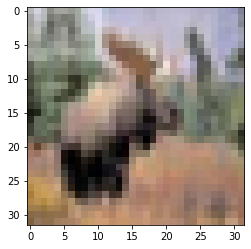

 deer


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(model.trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % model.classes[labels[j]] for j in range(1)))

In [ ]:
len(model.trainset)

50000

In [ ]:
len(model.testset)

10000

In [ ]:
x,y = model.trainset[0]

In [ ]:
print('taille d\'une image : {}'.format(x.shape))

taille d'une image : torch.Size([3, 32, 32])


In [ ]:
model.model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (apool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
)

In [7]:
model.loadModel()
#model.trainModel(epochs=10)

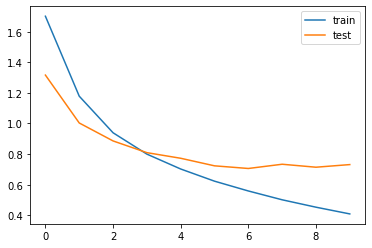

In [ ]:
train_loss = model.history_train
test_loss = model.history_test
epochs = [i for i in range(len(train_loss))]

fig = plt.figure()
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, test_loss, label='test')
plt.legend()
plt.show()

In [ ]:
model.testModel()

Accuracy of the network on the 10000 test images: 76 %


In [ ]:
import torch

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in model.testloader:
        inputs, labels = data[0].to(model.device), data[1].to(model.device)
        outputs = model.model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
model.saveModel()

True Label :ship


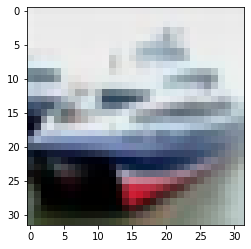

In [8]:
import numpy as np
index = 1

img = model.testset[index][0] / 2 + 0.5     # unnormalize
label = model.testset[index][1]
npimg = img.numpy()
print('True Label :' + classes[label])
plt.imshow(np.transpose(npimg, (1, 2, 0)))
#plt.show()

## Latent spaces exploration

In [ ]:
img
pred = model.identify(img)   
classes[pred]
print(len(model.model.layers))

In [10]:
def denormalize(img):
  return img / 2 + 0.5

In [11]:
fgsm = FGSM_Attack(model)
fgsm_params={'eps':0.05}

In [30]:
#take one prototype vect. per class
prototypes={}
for i in range(len(model.testset)):
  x = model.testset[i][0]
  x = denormalize(x)
  y = model.testset[i][1] 
  pred=classes[model.identify(x)]
  if pred not in prototypes.keys():
    latent_reps_p= [torch.flatten(t) for t in model.model.layers ]    #flatten the layers' outputs
    latent_reps_p= [ normalize(t) for t in latent_reps_p ]       #normalize them
    latent_reps_p= [ t.numpy() for t in latent_reps_p]       #turning the tensors into numpy arrays (just to fix an error occuring later)
    
    prototypes[pred]=  latent_reps_p

In [31]:
print(len(prototypes))
print(len(prototypes['deer']))

10
7


In [ ]:
normalize = lambda x: (x-torch.mean(x))/torch.std(x)
all_adv_latent_reps=[]
all_latent_reps=[]
keys=[]

for i in range(len(model.testset)):
  dist_mat=[]
  dist_mats=[]
  x = model.testset[i][0]
  x = denormalize(x)
  y = model.testset[i][1]
  
  pred=classes[model.identify(x)]
  latent_reps=model.model.layers

  #generate adversarial

  x = (x[None, ...]).to(model.device)
  y = torch.tensor([y]).to(model.device)

  adv_x =fgsm.generate_adv(x,y, targeted=True,
                               **fgsm_params)
  adv_x= torch.squeeze(denormalize(adv_x), 0)
  pred_adv=classes[model.identify(adv_x)]
  if pred==pred_adv:
    continue 
  
  latent_reps= [torch.flatten(t) for t in latent_reps]    #flatten the layers' outputs
  latent_reps= [ normalize(t) for t in latent_reps]       #normalize them
  latent_reps= [ t.numpy() for t in latent_reps]          #turning the tensors into numpy arrays (just to fix an error occuring later)

  #construct the lists for PCA
  all_latent_reps.append(prototypes[pred_adv])
  
  adv_latent_reps=model.model.layers
  adv_latent_reps= [torch.flatten(t) for t in adv_latent_reps]
  adv_latent_reps= [normalize(t) for t in adv_latent_reps] 
  adv_latent_reps= [ t.numpy() for t in adv_latent_reps]
  all_adv_latent_reps.append(adv_latent_reps) 

  processed_pair=str(i)+'-'+pred+'-'+ pred_adv
  keys.append(processed_pair)


Making all layers' output vectors of same dimension

In [ ]:
nc=int(np.min([8192, 4096, 2048, 512, 512, 128, 10]))
print(nc)
#pca objet for each layer
pca1= PCA(n_components=nc)
pca2= PCA(n_components=nc)
pca3= PCA(n_components=nc)
pca4= PCA(n_components=nc)
pca5= PCA(n_components=nc)
pca6= PCA(n_components=nc)
pca7= PCA(n_components=nc)


np_all_latent_reps=np.array(all_latent_reps, dtype=object)
np_all_adv_latent_reps= np.array(all_adv_latent_reps, dtype=object)
strt=time()
print("fitting pca object 1...")
pca1.fit(np_all_latent_reps[:,0].tolist()+ np_all_adv_latent_reps[:,0].tolist())
print("fitting pca object 2...")
pca2.fit(np_all_latent_reps[:,1].tolist()+np_all_adv_latent_reps[:,1].tolist())
print("fitting pca object 3...")
pca3.fit(np_all_latent_reps[:,2].tolist()+np_all_adv_latent_reps[:,2].tolist()) 
print("fitting pca object 4...")
pca4.fit(np_all_latent_reps[:,3].tolist()+np_all_adv_latent_reps[:,3].tolist()) 
print("fitting pca object 5...")
pca5.fit(np_all_latent_reps[:,4].tolist()+np_all_adv_latent_reps[:,4].tolist())
print("fitting pca object 6...")
pca6.fit(np_all_latent_reps[:,5].tolist()+np_all_adv_latent_reps[:,5].tolist())
print("fitting pca object 7...")
pca7.fit(np_all_latent_reps[:,6].tolist()+np_all_adv_latent_reps[:,6].tolist()) 
print("exec time ", time()-strt)

pca=[pca1,pca2,pca3,pca4,pca5,pca6,pca7]

Compute the distances

In [35]:
pairs_dict={}

for i in range(np_all_latent_reps.shape[0]):
  dist_mat=[]
  dist_mats=[]
  pairs_dict[keys[i]]=[]
  for j in range(len(latent_reps)):

    new_rep=pca[j].transform(all_latent_reps[i][j].reshape(1, -1))
    new_rep_adv=pca[j].transform(all_adv_latent_reps[i][j].reshape(1, -1))
    
    pairs_dict[keys[i]].append(euclidean(new_rep,new_rep_adv))   #compute euclidean distance over each pair (hidden_layer_i(original), hidden_layer_i(adversarial)) 

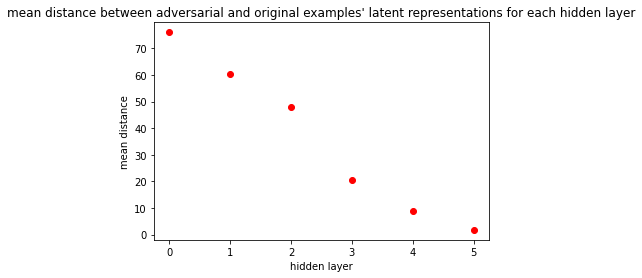

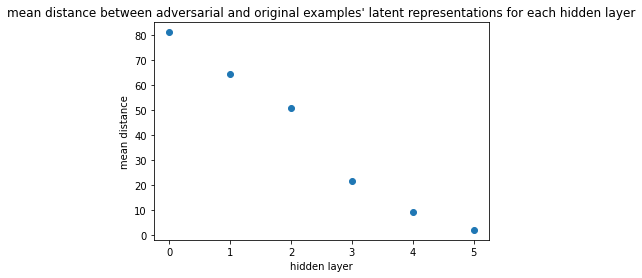

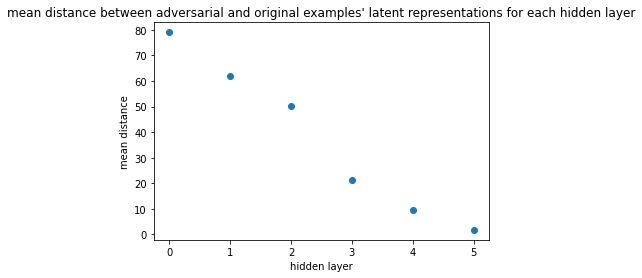

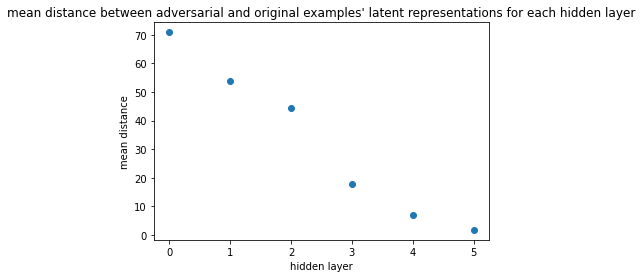

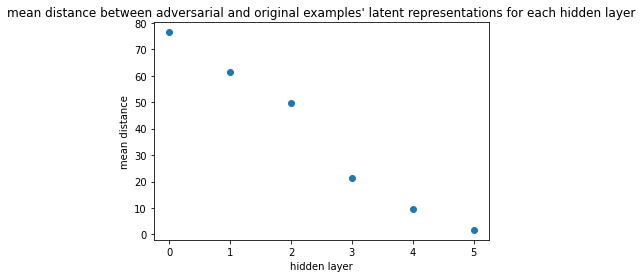

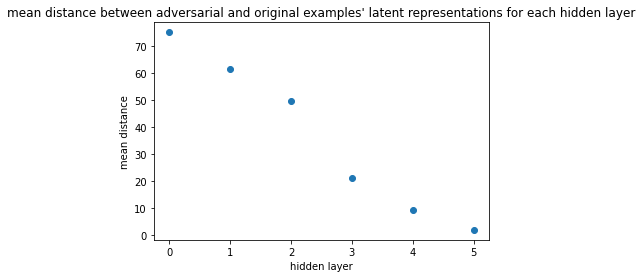

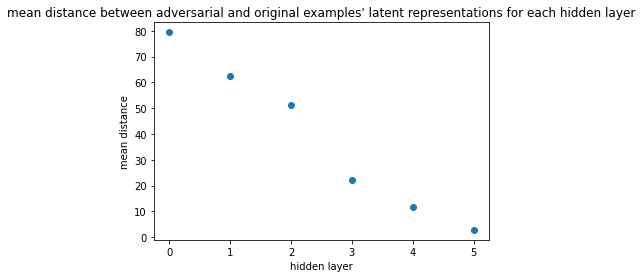

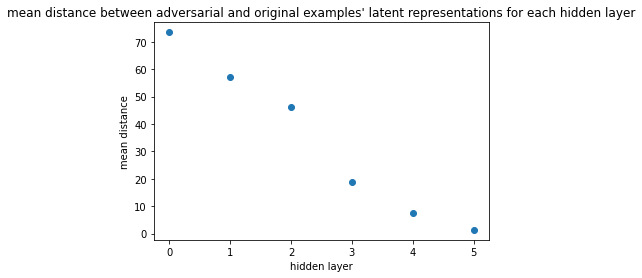

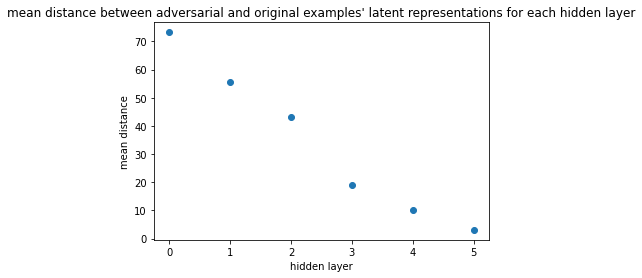

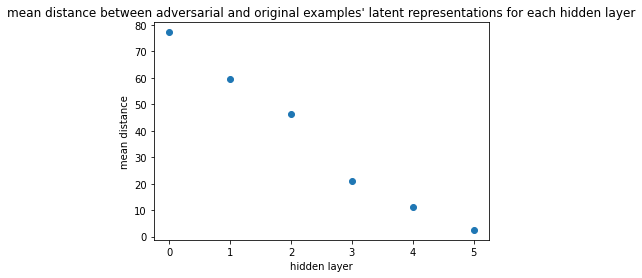

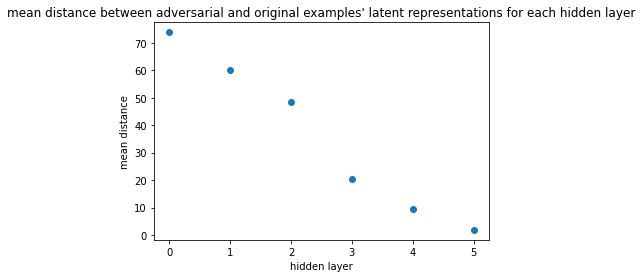

In [48]:
#plot pairs of the mean distances for each hidden layer

tensor_dists= torch.FloatTensor([pairs_dict[key] for key in pairs_dict.keys()])
tensor_dists=torch.cat((tensor_dists[:,:4], tensor_dists[:,5:]),1)
mean_dists= torch.mean(tensor_dists, 0)
#plot the mean distances 
plt.scatter(range(len(mean_dists)),mean_dists, c='red')

plt.ylabel("mean distance")
plt.xlabel("hidden layer")
plt.title("mean distance between adversarial and original examples' latent representations for each hidden layer")
plt.show()

#plot some individual distance pairs (just to check if the distances are not much different from the mean (should see std deviation instead))
for i in range(3):
  plt.scatter(range(len(tensor_dists[i])),tensor_dists[i])
  plt.ylabel("mean distance")
  plt.xlabel("hidden layer")
  plt.title("mean distance between adversarial and original examples' latent representations for each hidden layer")
  plt.show()